In [4]:
import pandas as pd
import numpy as np
import seaborn as sn
import json
sn.set_theme(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [5]:
def json_to_df(json_file: str) -> pd.DataFrame:
    with open(json_file) as f:
        data = json.load(f)
        f.close()
        
    instance_id_list = []
    goal_achieved_list = []
    content_list = []
    actions_text_list = []
    actions_possible_list = []
    n_actions_list = []
    for instance_id, value in data.items():
        value = value["chat_with_possible_actions"]
        goal_achieved = value["goal_achieved"]
        content = value["content"]
        actions = value["actions"]
        actions_text = [action[0] for _ , action in actions.items()]
        n_actions = len(actions_text)
        actions_possible = [str(int(action[1])) for _ , action in actions.items()]
        actions_text = ".".join(actions_text)
        actions_possible = ".".join(actions_possible)
        
        instance_id_list.append(instance_id)
        goal_achieved_list.append(goal_achieved)
        content_list.append(content)
        actions_text_list.append(actions_text)
        actions_possible_list.append(actions_possible)
        n_actions_list.append(n_actions)

    df = pd.DataFrame({
        "instance_id": instance_id_list,
        "goal_achieved": goal_achieved_list,
        "content": content,
        "actions_text": actions_text_list,
        "actions_possible": actions_possible_list,
        "n_actions": n_actions_list
    })
    
    return df

In [6]:
def json_to_df_without_checking_actions(json_file: str) -> pd.DataFrame:
    with open(json_file) as f:
        data = json.load(f)
        f.close()
    instance_id_list = []
    goal_achieved_list = []
    content_list = []
    actions_text_list = []
    n_actions_list = []
    
    for instance_id, value in data.items():
        value = value["chat_with_possible_actions"]
        goal_achieved = value["goal_achieved"]
        content = value["content"]
        actions = value["actions"]
        actions_text = [action for action in actions]
        n_actions = len(actions_text)
        actions_text = ".".join(actions_text)
        
        instance_id_list.append(instance_id)
        goal_achieved_list.append(goal_achieved)
        content_list.append(content)
        actions_text_list.append(actions_text)
        n_actions_list.append(n_actions)

    df = pd.DataFrame({
        "instance_id": instance_id_list,
        "goal_achieved": goal_achieved_list,
        "content": content,
        "actions_text": actions_text_list,
        "n_actions": n_actions_list
    })
    
    return df
    

In [7]:
def all_possible_actions(actions_possible: str):
    actions_possible = actions_possible.split(".")
    if "0" in actions_possible:
        return False
    return True

In [8]:
def pre_proc_df(df: pd.DataFrame) -> pd.DataFrame:
    df["all_possible_actions"] = df["actions_possible"].apply(all_possible_actions)
    df["correct_response"] = df["goal_achieved"] & df["all_possible_actions"]
    return df

In [9]:
def get_acc(df: pd.DataFrame) -> float:
    return df["correct_response"].sum() / df.shape[0]

In [10]:
def get_n_actions_from_plan(plan: str) -> int:
    return len(plan.split("\n")) - 1

In [11]:
def get_ground_truth_df(ground_truth_file: str) -> pd.DataFrame:
    with open(ground_truth_file) as f:
        data = json.load(f)
        f.close()
    ground_truth_plan_list = [value["ground_truth_plan"] for value in data["instances"]]
    instance_id_list = [value["instance_id"]-1 for value in data["instances"]]
    df = pd.DataFrame(ground_truth_plan_list, columns=["ground_truth_plan"])
    df["instance_id"] = instance_id_list
    df["ground_truth_n_actions"] = df["ground_truth_plan"].apply(get_n_actions_from_plan)
    return df

In [12]:
def pre_proc_ground_truth(df: pd.DataFrame, df_ground_truth: pd.DataFrame) -> pd.DataFrame:
    instance_id = [100]
    instance_id.extend(range(1, 100))
    df["instance_id"] = instance_id
    df = df.merge(df_ground_truth, on="instance_id")
    return df

In [13]:
def get_mean_n_actions(df):
    return df[df["correct_response"] == True]["ground_truth_n_actions"].mean()

In [14]:
def get_ground_truth_n_actions(df):
    n_actions = df[df["correct_response"] == True]["ground_truth_n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [15]:
def get_n_actions(df):
    n_actions = df[df["correct_response"] == True]["n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [16]:
def get_all_n_actions(df):
    n_actions = df["n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [18]:
ground_truth_df = get_ground_truth_df("data/prompts/blocksworld_3/task_1_plan_generation.json")

In [19]:
df_only_prompt = json_to_df("experiments_results/json_goal_only_prompt_llama2:70b.json")
df_only_prompt = pre_proc_df(df_only_prompt)
df_only_prompt = pre_proc_ground_truth(df_only_prompt, ground_truth_df)

In [20]:
df_iterative_only_prompt = json_to_df("experiments_results/json_goal_iterative_llama2:70b.json")
df_iterative_only_prompt = pre_proc_df(df_iterative_only_prompt)
df_iterative_only_prompt = pre_proc_ground_truth(df_iterative_only_prompt, ground_truth_df)

In [21]:
df_iterative_full_plan = json_to_df("experiments_results/json_goal_only_prompt_iterative_llama2:70b.json")
df_iterative_full_plan = pre_proc_df(df_iterative_full_plan)
df_iterative_full_plan = pre_proc_ground_truth(df_iterative_full_plan, ground_truth_df)

In [22]:
df_chat = json_to_df("experiments_results/json_goal_chat_llama2:70b.json")
df_chat["correct_response"] = df_chat["goal_achieved"]
df_chat = pre_proc_ground_truth(df_chat, ground_truth_df)

In [23]:
df_with_possible_actions = json_to_df_without_checking_actions("experiments_results/json_goal_chat_with_possible_actions_llama2:70b.json")
df_with_possible_actions["correct_response"] = df_with_possible_actions["goal_achieved"]
df_with_possible_actions = pre_proc_ground_truth(df_with_possible_actions, ground_truth_df)

In [24]:
names_list = ["Full Plan", "Iterative Action", "Validation Full Plan", "Validation Iterative Action", "Possible Actions"]
df_list = [df_only_prompt, df_iterative_only_prompt, df_iterative_full_plan, df_chat, df_with_possible_actions]
acc_list = list(map(get_acc, df_list))
n_actions_mean_list = list(map(get_mean_n_actions, df_list))
ground_truth_n_actions_list = list(map(get_ground_truth_n_actions, df_list))
n_actions_list = list(map(get_n_actions, df_list))
all_n_actions_list = list(map(get_all_n_actions, df_list))

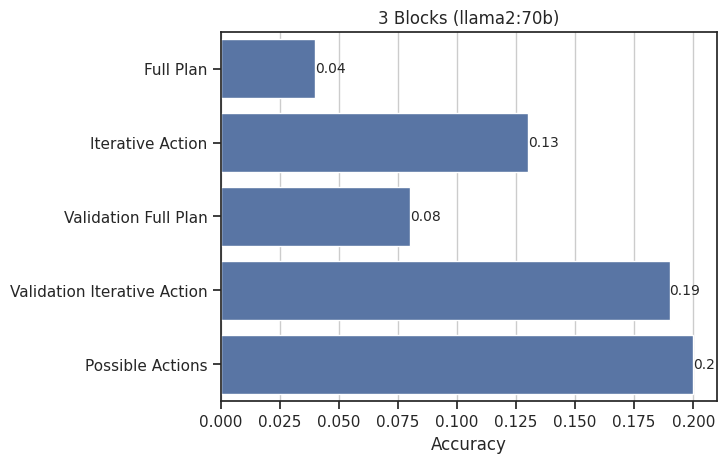

In [36]:
ax = sn.barplot(x=acc_list, y=names_list, orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlabel("Accuracy");
ax.set_title("3 Blocks (llama2:70b)");

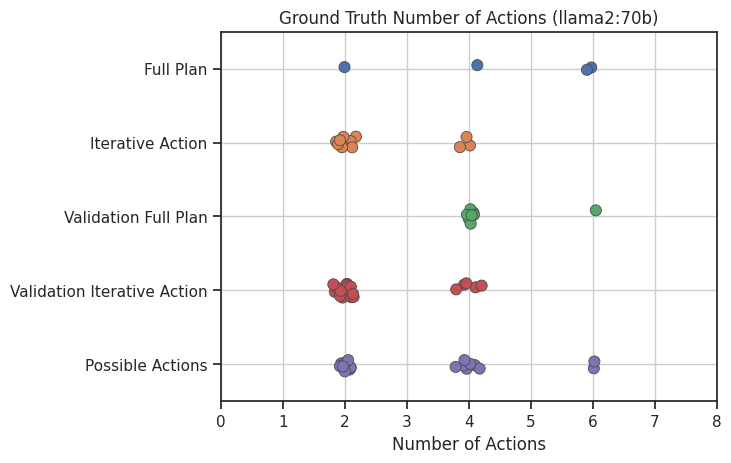

In [35]:
sn.set_theme(style="ticks")
ax = sn.stripplot(ground_truth_n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_yticklabels(names_list)
ax.set_xlim([0, 8])
ax.set_xlabel("Number of Actions");
ax.set_title("Ground Truth Number of Actions (llama2:70b)");

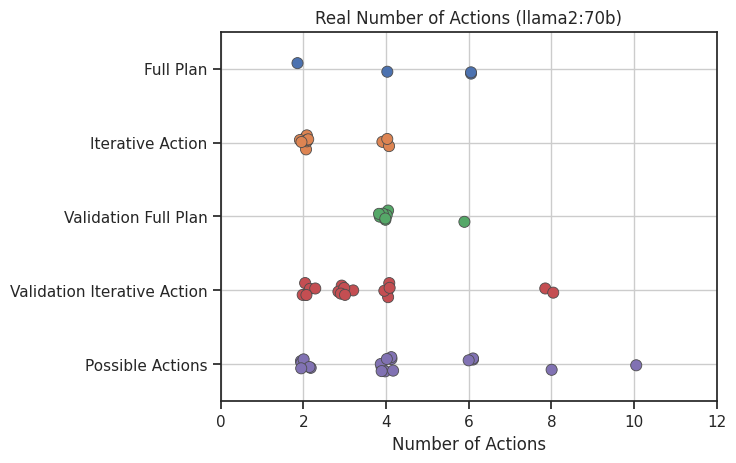

In [34]:
sn.set_theme(style="ticks")
ax = sn.stripplot(n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("Real Number of Actions (llama2:70b)");

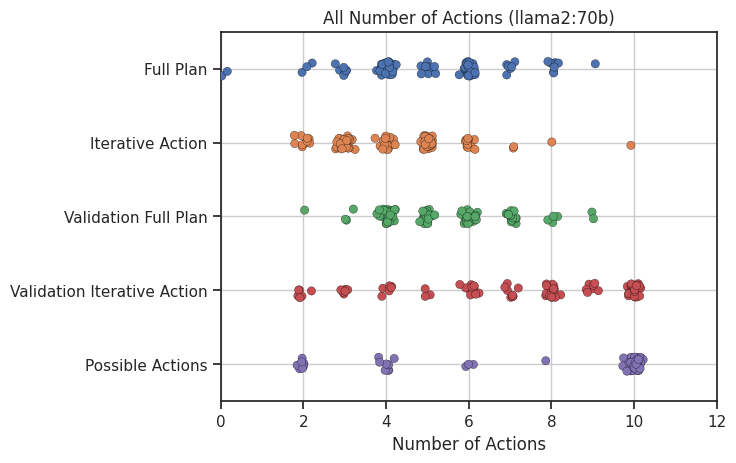

In [37]:
sn.set_theme(style="ticks")
ax = sn.stripplot(all_n_actions_list, orient="h", size=6, edgecolor="Black", linewidth=0.2)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("All Number of Actions (llama2:70b)");

In [64]:
df.groupby("action_possible_inference").count()

,Unnamed: 0,instance_id,action,current_state,action_possible,model_return
action_possible_inference,,,,,,
-1,1,1,1,1,1,1
1,286,286,286,286,286,286
2,181,181,181,181,181,181


In [65]:
df = df[df["action_possible_inference"] != -1]

In [66]:
del df["Unnamed: 0"]

In [3]:
def aplly_func(x):
    if x == 2:
        return 0
    return x

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, precision_recall_curve
import seaborn as sn

def get_metrics_from_dataframe(df_file: str):
    df = pd.read_csv(df_file)
    df = df[df["action_possible_inference"] != -1]
    df["action_possible"] = df["action_possible"].apply(aplly_func)
    df["action_possible_inference"] = df["action_possible_inference"].apply(aplly_func)
    y_true = df["action_possible"]
    y_hat = df["action_possible_inference"]
    
    cm = confusion_matrix(y_true, y_hat)
    acc = accuracy_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    precision = precision_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)
    
    return cm, acc, recall, precision, f1

In [5]:
cm_1, acc_1, recall_1, precision_1, f1_1 = get_metrics_from_dataframe("experiments_results/action_validation_dataset_1_101_3_llama2:13b-chat.csv")

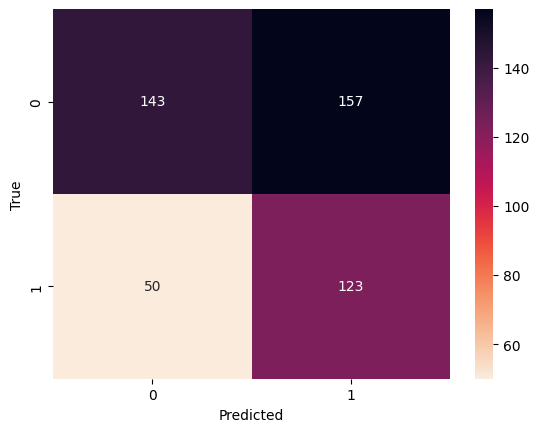

In [6]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_1, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [7]:
print("Acc: ", acc_1)
print("Recall: ", recall_1)
print("Precision: ", precision_1)
print("F1: ", f1_1)

Acc:  0.5623678646934461
Recall:  0.7109826589595376
Precision:  0.4392857142857143
F1:  0.543046357615894


In [8]:
cm_2, acc_2, recall_2, precision_2, f1_2 = get_metrics_from_dataframe("experiments_results/action_validation_dataset_1_101_3_mistral.csv")

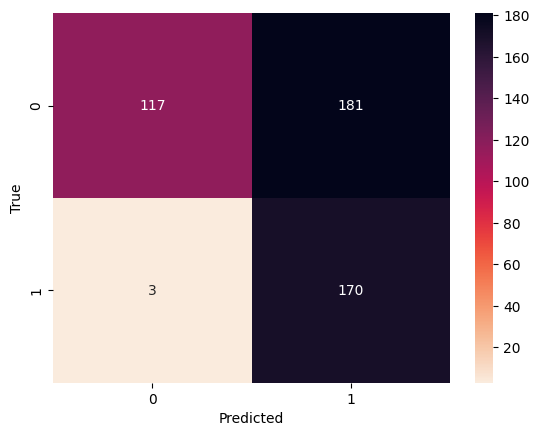

In [9]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_2, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [10]:
print("Acc: ", acc_2)
print("Recall: ", recall_2)
print("Precision: ", precision_2)
print("F1: ", f1_1)

Acc:  0.6093418259023354
Recall:  0.9826589595375722
Precision:  0.4843304843304843
F1:  0.543046357615894


In [11]:
cm_3, acc_3, recall_3, precision_3, f1_3 = get_metrics_from_dataframe("experiments_results/action_validation_dataset_1_101_3_gpt-4-0125-preview.csv")

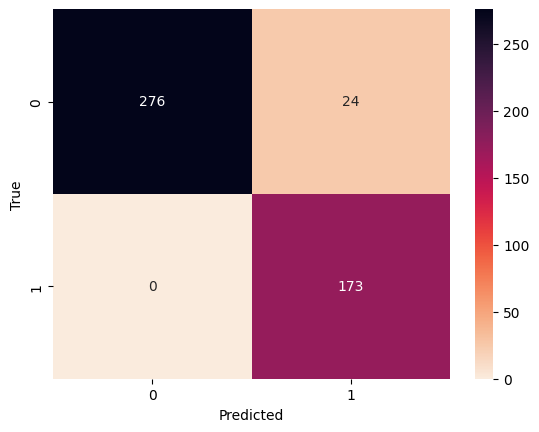

In [12]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_3, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [13]:
print("Acc: ", acc_3)
print("Recall: ", recall_3)
print("Precision: ", precision_3)
print("F1: ", f1_3)

Acc:  0.9492600422832981
Recall:  1.0
Precision:  0.8781725888324873
F1:  0.935135135135135


In [14]:
cm_4, acc_4, recall_4, precision_4, f1_4 = get_metrics_from_dataframe("experiments_results/4_blocks_action_validation_1_101_5_mistral.csv")

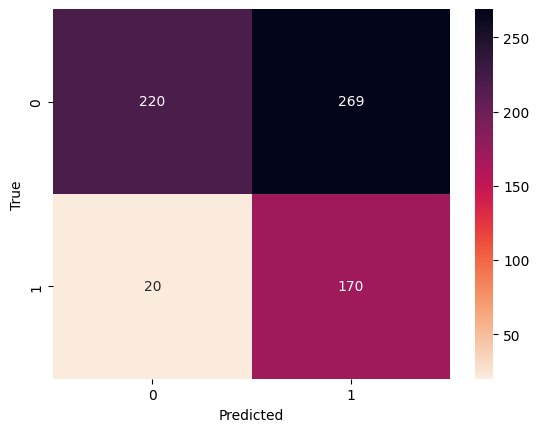

In [15]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_4, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [16]:
print("Acc: ", acc_4)
print("Recall: ", recall_4)
print("Precision: ", precision_4)
print("F1: ", f1_4)

Acc:  0.5743740795287187
Recall:  0.8947368421052632
Precision:  0.38724373576309795
F1:  0.5405405405405406


In [17]:
cm_5, acc_5, recall_5, precision_5, f1_5 = get_metrics_from_dataframe("experiments_results/4_blocks_action_validation_1_101_5_llama2:13b-chat.csv")

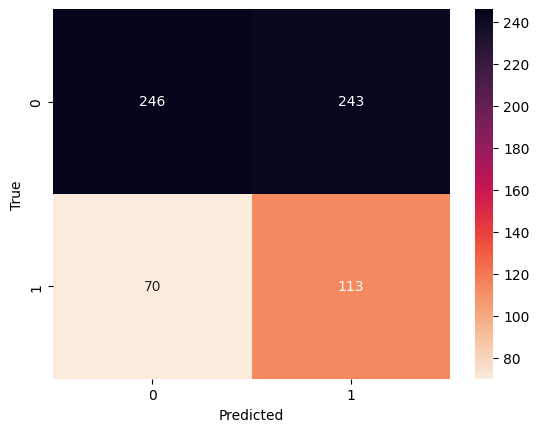

In [18]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_5, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [19]:
print("Acc: ", acc_5)
print("Recall: ", recall_5)
print("Precision: ", precision_5)
print("F1: ", f1_5)

Acc:  0.5342261904761905
Recall:  0.6174863387978142
Precision:  0.31741573033707865
F1:  0.41929499072356213


In [20]:
cm_6, acc_6, recall_6, precision_6, f1_6 = get_metrics_from_dataframe("experiments_results/8_blocks_action_validation_1_101_8_mistral.csv")

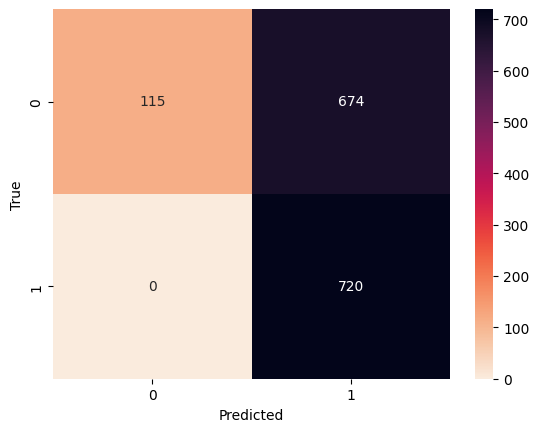

In [22]:
cmap = sn.cm.rocket_r

s = sn.heatmap(cm_6, annot=True, fmt="g", cmap=cmap)
s.set_xlabel("Predicted")
s.set_ylabel("True");

In [23]:
print("Acc: ", acc_6)
print("Recall: ", recall_6)
print("Precision: ", precision_6)
print("F1: ", f1_6)

Acc:  0.5533465871438038
Recall:  1.0
Precision:  0.5164992826398852
F1:  0.6811731315042573


In [3]:
df = pd.read_csv("experiments_results/blocks_action_generation_1_101_mistral.csv")

In [9]:
df[df["action_possible"] == 1].shape[0] / df.shape[0]

0.36

In [10]:
df = pd.read_csv("experiments_results/blocks_action_generation_1_101_llama2:13b-chat.csv")

In [11]:
df[df["action_possible"] == 1].shape[0] / df.shape[0]

0.39

In [12]:
df = pd.read_csv("experiments_results/blocks_action_generation_1_101_gpt-4-0125-preview.csv")

In [13]:
df[df["action_possible"] == 1].shape[0] / df.shape[0]

0.87

In [16]:
df = pd.read_csv("experiments_results/4_blocks_action_generation_1_201_mistral.csv")

In [18]:
df.groupby("action_possible").count()

,Unnamed: 0.1,Unnamed: 0,instance_id,current_state,goal_text,possible_actions,model_return,action
action_possible,,,,,,,,
-1,11,11,11,11,11,11,11,11
0,113,113,113,113,113,113,113,113
1,76,76,76,76,76,76,76,76


In [15]:
df[df["action_possible"] == 1].shape[0] / df.shape[0]

0.38

In [19]:
df = pd.read_csv("experiments_results/8_blocks_action_generation_1_201_mistral.csv")

In [20]:
df.groupby("action_possible").count()

,Unnamed: 0.1,Unnamed: 0,instance_id,current_state,goal_text,possible_actions,model_return,action
action_possible,,,,,,,,
1,200,200,200,200,200,200,200,200


In [23]:
df["action"]

0        pick up the green block
1          pick up the red block
2      pick up the magenta block
3         pick up the blue block
4      pick up the magenta block
                 ...            
195     pick up the yellow block
196     pick up the yellow block
197    pick up the magenta block
198      pick up the green block
199     pick up the orange block
Name: action, Length: 200, dtype: object

In [24]:
df = pd.read_csv("experiments_results/blocks_action_generation_rank_1_101_mistral.csv")

In [25]:
df.groupby("action_possible").count()

,Unnamed: 0.1,Unnamed: 0,instance_id,current_state,goal_text,possible_actions,rank,model_return,action
action_possible,,,,,,,,,
-1,4,4,4,4,4,4,4,4,4
0,99,99,99,99,99,99,99,99,99
1,97,97,97,97,97,97,97,97,97


In [2]:
import pandas as pd
import json

In [3]:
def get_df_from_json(json_file: str):
    with open(json_file) as f:
        data = json.load(f)
        f.close()
    df = pd.DataFrame([(key, value["chat_with_possible_actions"]["goal_achieved"]) for key, value in data.items()])
    df.columns = ["instance_id", "goal_achieved"]
    return df

In [4]:
df_only_prompt = get_df_from_json("experiments_results/json_goal_only_prompt_llama2:70b.json")
df_only_prompt["goal_achieved"].sum() / df_only_prompt["goal_achieved"].count()

0.08

In [5]:
df_iterative = get_df_from_json("experiments_results/json_goal_iterative_llama2:70b.json")
df_iterative["goal_achieved"].sum() / df_iterative["goal_achieved"].count()

0.1

In [6]:
df_prompt_iterative = get_df_from_json("experiments_results/json_goal_only_prompt_iterative_llama2:70b.json")
df_prompt_iterative["goal_achieved"].sum() / df_prompt_iterative["goal_achieved"].count()

0.18

In [7]:
df_chat = get_df_from_json("experiments_results/json_goal_chat_llama2:70b.json")
df_chat["goal_achieved"].sum() / df_chat["goal_achieved"].count()

0.19

In [8]:
df_possible_actions = get_df_from_json("experiments_results/json_goal_chat_with_possible_actions_llama2:70b.json")
df_possible_actions["goal_achieved"].sum() / df_possible_actions["goal_achieved"].count()

0.2